# SeaRose Ice Incursion Incident 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 10
import numpy as np
from importlib import reload
from icedef import simulator, plot

In [12]:
plt.rcParams['figure.figsize'] = (10, 10)

## March 29, 2017

In [2]:
iceberg_start_time = np.datetime64('2017-03-29T01:45')
iceberg_start_latitude = 46.85639904
iceberg_start_longitude = -48.03872578
searose_latitude = 46.78851
searose_longitude = -48.01405

# Simulation

In [3]:
start_time = iceberg_start_time
end_time = iceberg_start_time + np.timedelta64(12, 'h')
time_frame = start_time, end_time
start_location = iceberg_start_latitude, iceberg_start_longitude

In [4]:
sim = simulator.Simulator(time_frame, start_location)

Attempting to download http://icedef.munroelab.ca/data/ECMWF/ocean/daily/20170329.nc... done.
Attempting to download http://icedef.munroelab.ca/data/ECMWF/ocean/daily/20170330.nc... done.
Attempting to download http://icedef.munroelab.ca/data/NARR/atm/daily/20170329.nc... done.
Attempting to download http://icedef.munroelab.ca/data/NARR/atm/daily/20170330.nc... done.


In [5]:
sim.run_simulation(label='default')
sim.run_simulation(label='1x1', **{'Ca': 1, 'Cw': 1})
sim.run_simulation(label='1x3', **{'Ca': 1, 'Cw': 3})
sim.run_simulation(label='1x5', **{'Ca': 1, 'Cw': 5})
sim.run_simulation(label='1x7', **{'Ca': 1, 'Cw': 7})
sim.run_simulation(label='3x1', **{'Ca': 3, 'Cw': 1})
sim.run_simulation(label='3x3', **{'Ca': 3, 'Cw': 3})
sim.run_simulation(label='3x5', **{'Ca': 3, 'Cw': 5})
sim.run_simulation(label='3x7', **{'Ca': 3, 'Cw': 7})

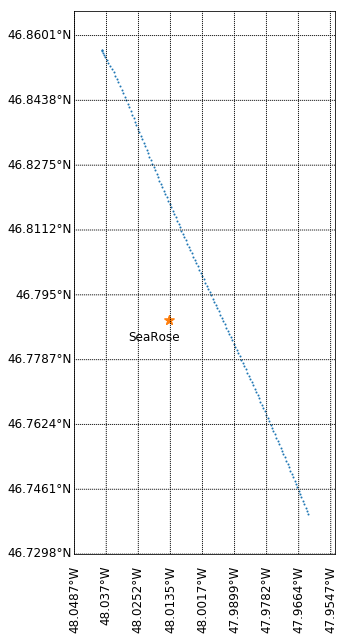

In [13]:
annotation_args = {'s': 'SeaRose', 'xy': (searose_longitude - 0.015, searose_latitude - 0.005)}
sizes = [1, 100]
markers = ['o', '*']
kwargs = {'annotation_args': annotation_args, 'markers': markers, 'sizes': sizes}
fig, ax = plot.plot_track([sim.results.data['default'].latitude.values, sim.results.data['default'].longitude.values],
                          [[searose_latitude, searose_latitude], [searose_longitude, searose_longitude]], **kwargs)
fig.savefig('./plots/searose_deterministic.png', bbox_inches='tight')

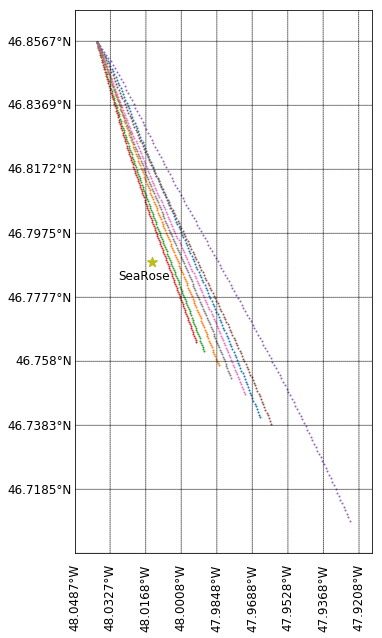

In [14]:
annotation_args = {'s': 'SeaRose', 'xy': (searose_longitude - 0.015, searose_latitude - 0.005)}
sizes = [1, 1, 1, 1, 1, 1, 1, 1, 100]
markers = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', '*']
kwargs = {'annotation_args': annotation_args, 'markers': markers, 'sizes': sizes}
fig, ax = plot.plot_track([sim.results.data['1x1'].latitude.values, sim.results.data['1x1'].longitude.values],
                          [sim.results.data['1x3'].latitude.values, sim.results.data['1x3'].longitude.values],
                          [sim.results.data['1x5'].latitude.values, sim.results.data['1x5'].longitude.values],
                          [sim.results.data['1x7'].latitude.values, sim.results.data['1x7'].longitude.values],
                          [sim.results.data['3x1'].latitude.values, sim.results.data['3x1'].longitude.values],
                          [sim.results.data['3x3'].latitude.values, sim.results.data['3x3'].longitude.values],
                          [sim.results.data['3x5'].latitude.values, sim.results.data['3x5'].longitude.values],
                          [sim.results.data['3x7'].latitude.values, sim.results.data['3x7'].longitude.values],
                          [[searose_latitude, searose_latitude], [searose_longitude, searose_longitude]], **kwargs)
fig.savefig('./plots/searose_ensemble.png', bbox_inches='tight')

# Husky Ice Management Plan

In [9]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
LARGE_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title


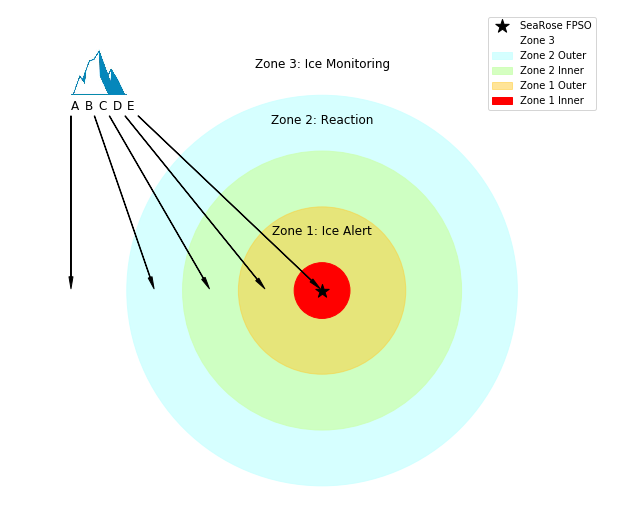

In [15]:
# RGBA codes
light_blue = (0.8, 1, 1, 0.8)
light_green = (0.8, 1, 0.7, 0.8)
light_orange = (1, 0.8, 0.2, 0.5)
light_red = (1, 0.2, 0.1, 0.5) 

circle0 = plt.Circle((0, 0), 0.8, color='white')
circle1 = plt.Circle((0, 0), 0.7, color=light_blue)
circle2 = plt.Circle((0, 0), 0.5, color=light_green)
circle3 = plt.Circle((0, 0), 0.3, color=light_orange)
circle4 = plt.Circle((0, 0), 0.1, color='red')

fig, ax = plt.subplots() 

ax.add_artist(circle0)
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)
ax.add_artist(circle4)

im = plt.imread('../images/iceberg_icon.png')
ax.imshow(im, extent=[-.9, -.7, .7, .9])

ax.set_xlim(-1, 1)
ax.set_ylim(-0.75, 1)

ax.set_axis_off()

arrow_properties = dict(
    facecolor="black", width=0.5,
    headwidth=4, shrink=0.01)

ax.annotate('A', xy=(-0.9, 0), xytext=(-0.9, .65), arrowprops=arrow_properties)
ax.annotate('B', xy=(-.6, .0), xytext=(-0.85, .65), arrowprops=arrow_properties)
ax.annotate('C', xy=(-.4, .0), xytext=(-0.80, .65), arrowprops=arrow_properties)
ax.annotate('D', xy=(-.2, .0), xytext=(-0.75, .65), arrowprops=arrow_properties)
ax.annotate('E', xy=(0, .0), xytext=(-0.70, .65), arrowprops=arrow_properties)

ax.annotate('Zone 3: Ice Monitoring', (0, 0.8), horizontalalignment='center')
ax.annotate('Zone 2: Reaction', (0, 0.6), horizontalalignment='center')
ax.annotate('Zone 1: Ice Alert', (0, 0.2), horizontalalignment='center')

fpso = ax.scatter(0, 0, marker='*', s=200, color='black', zorder=10, label='SeaRose FPSO')
ax.legend([fpso, circle0, circle1, circle2, circle3, circle4], 
          ['SeaRose FPSO', 'Zone 3', 'Zone 2 Outer', 'Zone 2 Inner', 'Zone 1 Outer', 'Zone 1 Inner'])
fig.savefig('./plots/husky_emp.png', bbox_inches='tight')
plt.show()